<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка данных</a></span></li><li><span><a href="#Умножение-матриц" data-toc-modified-id="Умножение-матриц-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Умножение матриц</a></span></li><li><span><a href="#Алгоритм-преобразования" data-toc-modified-id="Алгоритм-преобразования-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Алгоритм преобразования</a></span></li><li><span><a href="#Проверка-алгоритма" data-toc-modified-id="Проверка-алгоритма-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка алгоритма</a></span></li><li><span><a href="#Общий-вывод" data-toc-modified-id="Общий-вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Общий вывод</a></span></li></ul></div>

# Защита персональных данных клиентов

Вам нужно защитить данные клиентов страховой компании «Хоть потоп». Разработайте такой метод преобразования данных, чтобы по ним было сложно восстановить персональную информацию. Обоснуйте корректность его работы.

Нужно защитить данные, чтобы при преобразовании качество моделей машинного обучения не ухудшилось. Подбирать наилучшую модель не требуется.

## Загрузка данных

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm

In [2]:
SEED = 12345

sns.set_style('darkgrid')

In [3]:
def get_df(file_name):
    path_to_file = os.path.relpath(os.path.join('datasets/', file_name))
    if os.path.isfile(path_to_file):
        return pd.read_csv(path_to_file)
    raise Exception('Данные отсутствуют')

In [4]:
df = get_df('insurance.csv')

In [5]:
df.info()
df.sample(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Пол                5000 non-null   int64  
 1   Возраст            5000 non-null   float64
 2   Зарплата           5000 non-null   float64
 3   Члены семьи        5000 non-null   int64  
 4   Страховые выплаты  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
904,0,41.0,32500.0,0,0
4108,0,32.0,39400.0,0,0
1189,0,28.0,39800.0,1,0
2840,1,22.0,36200.0,1,0
1952,0,53.0,45200.0,0,2
169,1,38.0,40700.0,1,0
4852,0,40.0,39900.0,0,0
264,1,46.0,46500.0,1,1
81,1,29.0,51600.0,1,0
458,0,26.0,41400.0,4,0


In [6]:
def get_overview_histogram(df, col, ax, bins_num='auto', line_color='r',
                           color=None):
    ax.set_title(f'Распределение признака "{col}"')
    median = df[col].median()
    mean = df[col].mean()
    sns.histplot(df[col], kde=True, color=color, bins=bins_num, ax=ax)
    ax.axvline(x=median, c=line_color, label='Медиана')
    ax.axvline(x=mean, c=line_color, ls='--', label='Среднее')
    ax.set_ylabel('Количество')

def get_overview(df):
    fig, axs = plt.subplots(2, 3, figsize=(15, 7))
    fig.delaxes(axs[1][2])
    cols = df.columns
    for col, ax in tqdm(zip(cols, axs.flat)):
        get_overview_histogram(df, col, ax)

    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.52, 1), fontsize=11)
    plt.show()

,Пол,Возраст,Зарплата,Члены семьи,Страховые выплаты
0.01,0.0,18.0,16599.0,0.0,0.0
0.99,1.0,52.0,62301.0,4.0,2.0


5it [00:00, 10.67it/s]


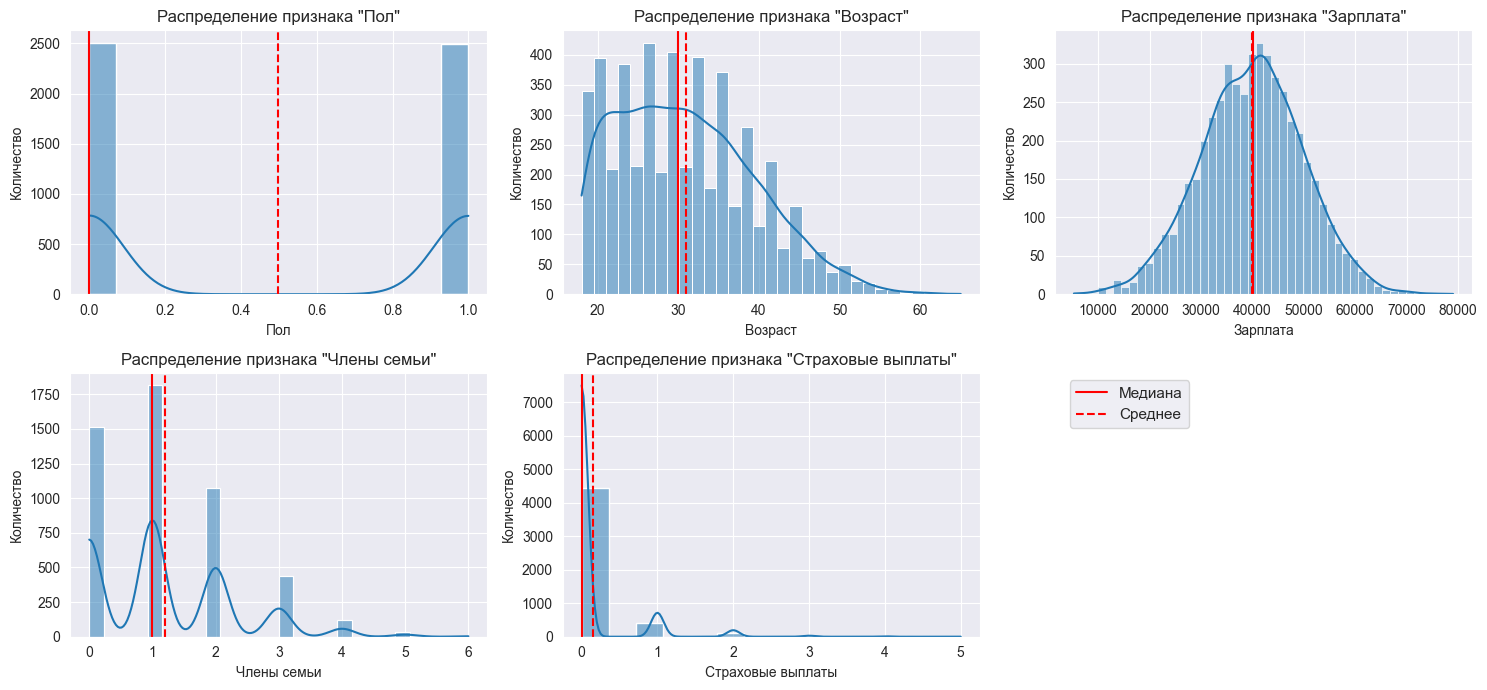

In [7]:
display(df.quantile([.01, .99]))
get_overview(df)

`Пол`  
Классы признака сбалансированы.  

`Возраст`  
Распределение скошено вправо.  
Основная часть значений лежит в диапазоне до 52 лет.

`Зарплата`  
Нормальное распределение.  
Основная часть значений лежит в диапазоне от 16599 до 62301.  

`Члены семьи`   
Количество членов семьи 99% клиентов не превышает 4-х.  

`Страховые выплаты`  
Основная часть клиентов за последние 5 лет не получала страховые выплаты.  

Аномальные значения в рассмотренных переменных отсутствуют.

In [8]:
print(df['Возраст'].astype('str').str.split('.').str[-1].value_counts())
df['Зарплата'].astype('str').str.split('.').str[-1].value_counts()

0    5000
Name: Возраст, dtype: int64


0               4960
000000000004      35
99999999999        3
00000000001        2
Name: Зарплата, dtype: int64

В столбце с зарплатой клиента содержится незначительное количество десятичных дробей, округлим их до целых и приведём типы данных в датасете.

In [9]:
df['Зарплата'] = df['Зарплата'].round(0)
print(df['Зарплата'].astype('str').str.split('.').str[-1].value_counts(), '\n')

df = df.apply(pd.to_numeric, downcast='integer')
df.info()

0    5000
Name: Зарплата, dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Пол                5000 non-null   int8 
 1   Возраст            5000 non-null   int8 
 2   Зарплата           5000 non-null   int32
 3   Члены семьи        5000 non-null   int8 
 4   Страховые выплаты  5000 non-null   int8 
dtypes: int32(1), int8(4)
memory usage: 39.2 KB


In [10]:
df.duplicated().sum()

153

В данных содержаться явные дубликаты, однако, с учётом малого количества признаков и отсутствия идентификационного номера клиента,  
их появление вполне ожидаемо.

**Вывод**:  
- загруженный набор данных состоит из пяти тысяч объектов, содержит четыре количественные и одну категориальную переменную;  
- пропуски и аномальные значения отсутствуют;  
- типы данных приведены;  
- присутствующие в датасете явные дубликаты, вероятно, не являются результатом технического сбоя или человеческой ошибки.

## Умножение матриц

Ответьте на вопрос и обоснуйте решение.   
Признаки умножают на обратимую матрицу. Изменится ли качество линейной регрессии? (Её можно обучить заново.)  
a. Изменится. Приведите примеры матриц.  
b. Не изменится. Укажите, как связаны параметры линейной регрессии в исходной задаче и в преобразованной.  

Обозначения:

- $X$ — матрица признаков (нулевой столбец состоит из единиц)

- $y$ — вектор целевого признака

- $P$ — матрица, на которую умножаются признаки

- $w$ — вектор весов линейной регрессии (нулевой элемент равен сдвигу)

Предсказания:

$$
a = Xw
$$

Задача обучения:

$$
w = \arg\min_w MSE(Xw, y)
$$

Формула обучения:

$$
w = (X^T X)^{-1} X^T y
$$

**Ответ:** не изменится

**Обоснование:** $$a' = XAw'$$ где $a'$ - предсказания модели на признаках X, умноженных на обратимую матрицу A.  
Тогда  $$w' = ((XA)^TXA)^{-1}(XA)^Ty$$
Преобразуем выражение, используя следующие свойства обратной матрицы:
$$(A_1A_2...A_{n-1}A_n)^{-1} = A_n^{-1}A_{n-1}^{-1}...A_2^{-1}A_1^{-1},$$ $$AA^{-1} = I,$$
где I – единичная матрица, A – обратимая матрица.  
$$w' = (A^T(X^TX)A)^{-1}A^TX^Ty = A^{-1}(X^TX)^{-1}(A^T)^{-1}A^TX^Ty = A^{-1}(X^TX)^{-1}X^Ty,$$
$$w' = A^{-1}w$$
Из чего следует, что $$a' = XAw' = XAA^{-1}w = Xw = a$$

**Вывод**: умножение признаков на обратимую матрицу не повлияет на качество линейной регрессии.

## Алгоритм преобразования

**Алгоритм**  
Выполним преобразование путём умножения матрицы признаков X на обратимую матрицу A:
$$X’ = XA$$

**Обоснование**  
Описанный выше алгоритм не повлияет на качество линейной регрессии.    
Умножение преобразованных признаков на матрицу, обратную A, вернёт исходные значения:
$$X’ A^{-1} = XAA^{-1} = X$$

## Проверка алгоритма

In [11]:
features = df.drop('Страховые выплаты', axis=1)
target = df['Страховые выплаты']


def encrypt_features(features):
    n = features.shape[1]
    state = np.random.RandomState(SEED)
    A = state.normal(loc=0.1, scale=0.05, size=(n, n))
    while np.isclose(np.linalg.det(A), 0):
        A = state.normal(loc=0.1, scale=0.05, size=(n, n))

    X = features.values @ A
    restored_features = X @ np.linalg.inv(A)
    restored_features = pd.DataFrame(data=restored_features,
                                     columns=features.columns)
    restored_features = restored_features.round(0)
    restored_features = restored_features.apply(pd.to_numeric,
                                                downcast='integer')
    return pd.DataFrame(data=X, columns=features.columns), restored_features


features_encrypted, restored_features = encrypt_features(features)

is_equal = restored_features.equals(features)
output_dict = {1: '', 0: ' не'}
print(f'Значения восстановленных признаков{output_dict[is_equal]}'
      ' соответствуют значениям исходных признаков.')

Значения восстановленных признаков соответствуют значениям исходных признаков.


In [12]:
def get_rmse_r2(X, y):
    regressor = LinearRegression(n_jobs=-1)
    pipe = make_pipeline(StandardScaler(),  regressor)
    result = cross_validate(
        regressor, X, y, n_jobs=-1,
        cv=KFold(5, random_state=SEED, shuffle=True),
        scoring=['neg_mean_absolute_error', 'neg_root_mean_squared_error',
                 'r2']
    )
    return (
        result['test_r2'].mean(),
        -result['test_neg_mean_absolute_error'].mean(),
        -result['test_neg_root_mean_squared_error'].mean(),
    )

In [13]:
original = get_rmse_r2(features, target)
encrypted = get_rmse_r2(features_encrypted, target)

pd.DataFrame(
    index=['r2', 'mae', 'rmse'],
    data={'Исходные признаки': original, 'Преобразованные признаки': encrypted}
)

,Исходные признаки,Преобразованные признаки
r2,0.418645,0.418645
mae,0.253369,0.253369
rmse,0.351249,0.351249


**Вывод**: метрики, полученные на исходных данных, соответствуют метрикам на преобразованных данных.

## Общий вывод

**Описание данных**  
- **Признаки**: пол, возраст и зарплата застрахованного, количество членов его семьи.  
- **Целевой признак**: количество страховых выплат клиенту за последние 5 лет.  

**Предварительный анализ данных**:  
- аномальные значения и пропуски в загруженном наборе данных отсутствуют;  
- присутствующие в датасете явные дубликаты, вероятно, не являются результатом технического сбоя или человеческой ошибки.  

**Ход исследования**:
- приведено доказательство отсутствия влияния на качество линейной регрессии преобразования признаков путём умножения на обратимую матрицу;  
- исходя из результатов, полученных на предыдущем шаге исследования, предложен алгоритм преобразования признаков;  
- проведено сравнения качества линейной регрессии на исходных и преобразованных данных с точки зрения метрик $r^2$, $mae$, $rmse$:  
    полученные при использовании преобразованных признаков метрики соответствуют метрикам, полученным на исходных данных.